https://medium.com/machine-learning-world/tutorial-counting-road-traffic-capacity-with-opencv-998580f1fbde
https://github.com/creotiv/object_detection_projects/tree/master/opencv_traffic_capacity_counting

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import time

%matplotlib inline

In [204]:
# Parameters
input_video_path = './examples/AB17-0830H.avi'
output_video_path = './examples/AB17-0830H_output.mp4'

video = cv.VideoCapture(input_video_path)
ret, test_frame = video.read()

fps = video.get(cv.CAP_PROP_FPS)
img_height = test_frame.shape[0]
img_width = test_frame.shape[1]

start_frame = 0
total_frames = 400

count = 0
while(total_frames == -1):
    ret, frame = video.read()
    if ret:
        count += 1
    else:
        total_frames = count
        break
    
video.release()

In [195]:
AREA_PTS = np.array([
    [0, 456], [477, 151], [549, 151], [529, 719], [0, 719], [0, 456],
    [937, 720], [585, 161], [638, 161], [1279, 540], [1279, 719], [937, 720]
])

In [172]:
def caclOccupancy(frame, area_pts):
    base_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    area_mask = cv.fillPoly(np.zeros(base_frame.shape, base_frame.dtype), 
                            [AREA_PTS], 
                            (255, 255, 255)
                           )[:, :, 0]

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # this used for noise reduction at night time
    frameGray = cv.cvtColor(base_frame, cv.COLOR_RGB2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(frameGray)

    # getting edges with Canny filter
    edges = cv.Canny(frameGray, 50, 70)
    # invert them to get white background
    edges = ~edges

    # blur with additional use of bilateralFilter to remove color noise
    blur = cv.bilateralFilter(cv.blur(edges,(21,21), 100),9,200,200)

    # threshold with ROI overlapping
    _, threshold = cv.threshold(blur,230, 255,cv.THRESH_BINARY)
    t = cv.bitwise_and(threshold, threshold, mask = area_mask)

    # counting capacity area
    free = np.count_nonzero(t)
    capacity = 1 - float(free)/np.count_nonzero(area_mask)

    # creating plot for debugging and visualization
    img = np.zeros(base_frame.shape, base_frame.dtype)
    img[:, :] = (0, 50, 0)
    mask = cv.bitwise_and(img, img, mask=area_mask)
    cv.addWeighted(mask, 1, base_frame, 1, 0, base_frame)

    return (base_frame, edges, blur, t, capacity)

In [205]:
font = cv.FONT_HERSHEY_SIMPLEX
video = cv.VideoCapture(input_video_path)
output_frames = []

pbar = tqdm(total_frames)

count = 0
while(total_frames == -1 or len(output_frames) < total_frames):
    ret, frame = video.read()
    if ret:
        if count >= start_frame:
            base_frame, edges, blur, t, capacity = caclOccupancy(frame, AREA_PTS)
            output_img = cv.putText(base_frame, 
                        "CAPACITY: {:.2%}".format(capacity),
                        (10, 50), 
                        font, 2, 
                        (255, 100, 200), 3, 
                        cv.LINE_AA)
            output_frames.append(output_img)
            pbar.update(1)
    else:
        break
    count += 1

pbar.close()

video.release()

### Outputs: capacity

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [206]:
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter()

opened = out.open(output_video_path, fourcc, fps, (img_width, img_height))

for img in output_frames:
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    out.write(img)
    
out.release()

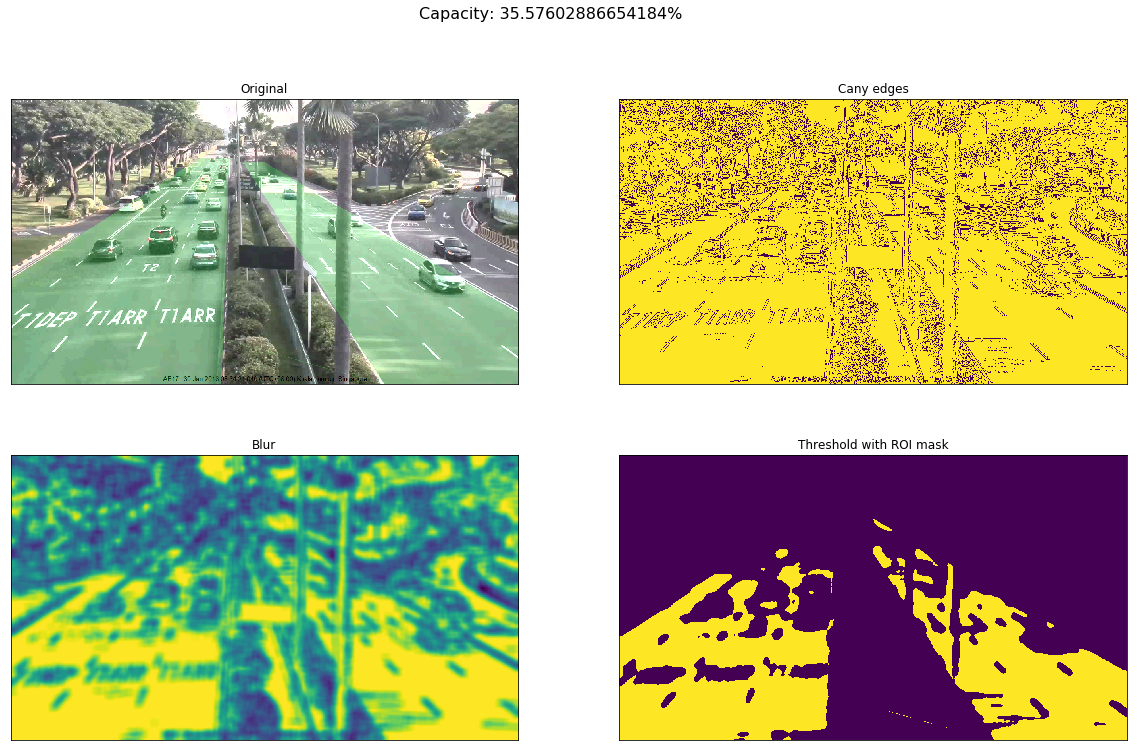

In [157]:
fig = plt.figure(figsize=(20,12))
fig.suptitle("Capacity: {}%".format(capacity*100), fontsize=16)
plt.subplot(221),plt.imshow(base_frame),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(edges),plt.title('Cany edges')
plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(blur),plt.title('Blur')
plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(t),plt.title('Threshold with ROI mask')
plt.xticks([]), plt.yticks([])

plt.show()